# Свёртка и предвыборка

1. Построить нейросети с линейными, свёрточными слоями и слоями подвыборки.
2. Проверить, какая конфигурация работает лучше линейных слоев.
3. Оценить качество предсказания по коэффициенту сходства.

## Подключение библиотек

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage import io

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import warnings
# warnings.filterwarnings('ignore')

## Используемые функции

In [2]:
image_x = 525
image_y = 350
image_ch = 3

def mask_rate(a, x, y):
    b = a // 1400 + 0.0
    return np.round(x*(b*x // 2100) + y*(a%1400) // 1400).astype("uint32")

def calc_mask(px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(" ")]).reshape(-1, 2)
    mask = np.zeros(y*x, dtype="uint8")
    for i, m in p:
        mask[mask_rate(i, x, y)-1:mask_rate(m + i, x, y)] = 1
    return mask.reshape(y, x).transpose()

def calc_dice(x):
    dice = 0
    px = x["EncodedPixels"]
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype="uint8")
        dice = 2*np.sum(target[mask==1]) / (np.sum(target) + np.sum(mask))
    
    return dice

## Загрузка данных

In [3]:
data = pd.read_csv("../data/clouds/train.csv.gz")

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print(data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


## Разделение данных

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
del data
print(train.head())

                                           EncodedPixels        Image Label
3204                                                 NaN  2404bd2.jpg  Fish
10848  32201 1367 33601 1367 35001 1367 36401 1367 37...  7b7d5ef.jpg  Fish
20560  440152 657 441552 657 442952 657 444352 657 44...  ecefc50.jpg  Fish
19472                                                NaN  e0d46d0.jpg  Fish
18240  1109543 533 1110943 533 1112343 533 1113743 53...  d2e7aa7.jpg  Fish


## Сверточная сеть

1. Данные загружаются пакетами
2. Функции для загрузки двух типов данных: графических из изображения и типа облака на изображении

In [16]:
def load_y(df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(-1, 1)


def load_x(df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)


def load_data(df, batch_size=20):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size
            batch_end += batch_size

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), strides=(2, 2), input_shape=(image_y, image_x, image_ch)),
    Activation("relu"),
    Conv2D(32, (3, 3), strides=(2, 2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Activation("softmax"),
    Dense(1)
])

## Топология модели

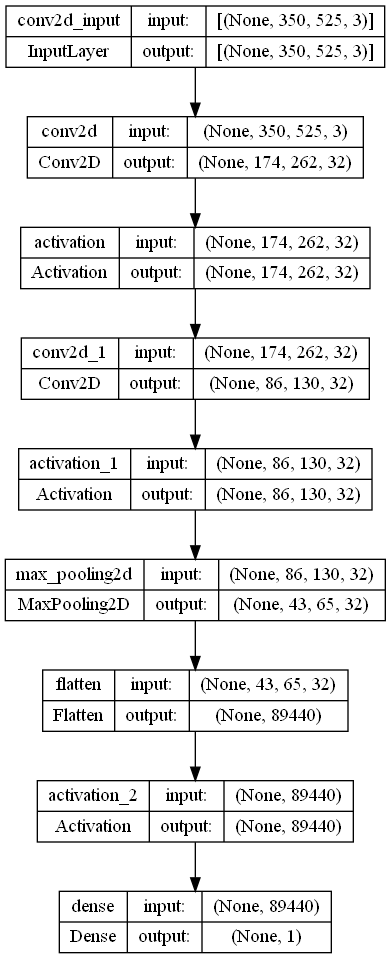

In [12]:
keras.utils.plot_model(
    model,
    to_file="../data/out/m10041.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB"
)

In [ ]:
filesDir = "../data/clouds/train_images_small/"
batch_size = 20

## Построить и обучить модель, используя градиентный спуск и абсолютную ошибку

In [13]:
model.compile(optimizer="adam", loss="mean_absolute_error")

In [ ]:
model.fit_generator(load_data(train, batch_size),
                    epochs=100,
                    steps_per_epoch=len(train)//batch_size,
                    verbose=True)

## Предсказание значений

In [ ]:
prediction = model.predict_generator(load_data(test, 1),
                                     steps=len(test),
                                     verbose=1)

In [ ]:
def draw_prediction(prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

In [ ]:
prediction = np.transpose(prediction)

In [ ]:
draw_prediction(prediction)

In [ ]:
test["target"] = (prediction[0] >= 1).astype("int8")
print(test[test["target"] > 0][["EncodedPixels", "target"]].head(20))

## Оценка по Дайсу

In [ ]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print("Keras, (CONV3-32x2, POOL2):", round(dice.mean(), 3))